In [1]:
!pip install pyautogen

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.5/593.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 34.4 MB/s eta 0:00:00


In [2]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_AI_STUDIO')

In [3]:
llm_config={"model": "gpt-4-turbo"}
# llm_config={"model": "gemini/gemini-2.0-pro-exp-02-05"}

# Chess Game

In [4]:
!pip install  chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148497 sha256=39e8ef0bd2be6298d61347a9c569b1926a842e56cb3ef63976045619adfe572d
  Stored in directory: /root/.cache/pip/wheels/f0/3f/76/8783033e8524d407e1bebaf72fdd3f3eba27e0c030e92bbd87
Successfully built chess


In [5]:
from IPython.display import SVG, display

In [6]:
import chess
import chess.svg
from typing_extensions import Annotated

# Initialize the Chess Board

In [7]:
board = chess.Board()

In [8]:
made_move = False

# tool for checking legal moves

In [9]:
def get_legal_moves(

) -> Annotated[str, "A list of legal moves in UCI format"]:
    return "Possible moves are: " + ",".join(
        [str(move) for move in board.legal_moves]
    )

# tool for making move on the board

In [10]:
def make_move(
    move: Annotated[str, "A move in UCI format."]
) -> Annotated[str, "Result of the move."]:
    move = chess.Move.from_uci(move)
    board.push_uci(str(move))
    global made_move
    made_move = True

    # Display the board using SVG
    display(SVG(chess.svg.board(
        board,
        arrows=[(move.from_square, move.to_square)],
        fill={move.from_square: "gray"},
        size=200
    )))

    # Rest of the function remains the same
    piece = board.piece_at(move.to_square)
    piece_symbol = piece.unicode_symbol()
    piece_name = (
        chess.piece_name(piece.piece_type).capitalize()
        if piece_symbol.isupper()
        else chess.piece_name(piece.piece_type)
    )
    return f"Moved {piece_name} ({piece_symbol}) from " \
    f"{chess.SQUARE_NAMES[move.from_square]} to " \
    f"{chess.SQUARE_NAMES[move.to_square]}."

# Creating Agents

In [ ]:
from autogen import ConversableAgent

In [12]:
# Player white agent
player_white = ConversableAgent(
    name="Player_White",
    system_message="You are a chess player and you play as white. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config=llm_config,
)

In [13]:
# Player black agent
player_black = ConversableAgent(
    name="Player_Black",
    system_message="You are a chess player and you play as black. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config=llm_config,
)

In [14]:
def check_made_move(msg):
    global made_move
    if made_move:
        made_move = False
        return True
    else:
        return False


In [15]:
board_proxy = ConversableAgent(
    name="Board_Proxy",
    llm_config=False,
    is_termination_msg=check_made_move,
    default_auto_reply="Please make a move.",
    human_input_mode="NEVER",
)

## Registering the tools

A tool must be registered for the agent that calls the tool and the agent that executes the tool.

In [16]:
from autogen import register_function

In [ ]:
for caller in [player_white, player_black]:
    register_function(
        get_legal_moves,
        caller=caller,
        executor=board_proxy,
        name="get_legal_moves",
        description="Get legal moves.",
    )

    register_function(
        make_move,
        caller=caller,
        executor=board_proxy,
        name="make_move",
        description="Call this tool to make a move.",
    )

In [18]:
player_black.llm_config["tools"]

[{'type': 'function',
  'function': {'description': 'Get legal moves.',
   'name': 'get_legal_moves',
   'parameters': {'type': 'object', 'properties': {}, 'required': []}}},
 {'type': 'function',
  'function': {'description': 'Call this tool to make a move.',
   'name': 'make_move',
   'parameters': {'type': 'object',
    'properties': {'move': {'type': 'string',
      'description': 'A move in UCI format.'}},
    'required': ['move']}}}]

## Register the nested chats

Each player agent will have a nested chat with the board proxy agent to
make moves on the chess board.

In [19]:
player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
            "summary_method": "last_msg",
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
            "summary_method": "last_msg",
        }
    ],
)

# Let's start the game

Player_Black (to Player_White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_White (to Board_Proxy):

***** Suggested tool call (call_0pXvcVUytCzNPGJyKR9qQ45Z): get_legal_moves *****
Arguments: 
{}
********************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION get_legal_moves...
Call ID: call_0pXvcVUytCzNPGJyKR9qQ45Z
Input arguments: {}
Board_Proxy (to Player_White):

***** Response from calling tool (c

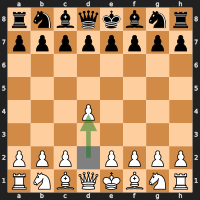

Board_Proxy (to Player_White):

***** Response from calling tool (call_rsjR7CYJe1KTi9zA7abRh1OA) *****
Moved pawn (♙) from d2 to d4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_White (to Board_Proxy):

I moved my pawn from d2 to d4. Your turn!

--------------------------------------------------------------------------------
Player_White (to Player_Black):

I moved my pawn from d2 to d4. Your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_Black):

I moved my pawn from d2 to d4. Your turn!

------------------------------------------------------------------------------

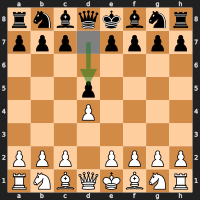

Board_Proxy (to Player_Black):

***** Response from calling tool (call_UU4TQJzyM046m4GpnqzkEgay) *****
Moved pawn (♟) from d7 to d5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_Black (to Board_Proxy):

I've moved my pawn from d7 to d5. It's your turn now!

--------------------------------------------------------------------------------
Player_Black (to Player_White):

I've moved my pawn from d7 to d5. It's your turn now!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_White):

I've moved my pawn from d7 to d5. It's your turn now!

------------------------------------------

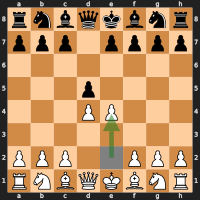

Board_Proxy (to Player_White):

***** Response from calling tool (call_DAMA0xrd59eHfBhEIPvpT79L) *****
Moved pawn (♙) from e2 to e4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_White (to Board_Proxy):

I've moved my pawn from e2 to e4. Your turn!

--------------------------------------------------------------------------------
Player_White (to Player_Black):

I've moved my pawn from e2 to e4. Your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_Black):

I've moved my pawn from e2 to e4. Your turn!

---------------------------------------------------------------------

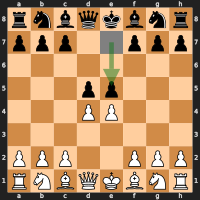

Board_Proxy (to Player_Black):

***** Response from calling tool (call_lC59zDgas7qxxV1arVnT3JxY) *****
Moved pawn (♟) from e7 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_Black (to Board_Proxy):

I've moved my pawn from e7 to e5. It's your move!

--------------------------------------------------------------------------------
Player_Black (to Player_White):

I've moved my pawn from e7 to e5. It's your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_White):

I've moved my pawn from e7 to e5. It's your move!

------------------------------------------------------

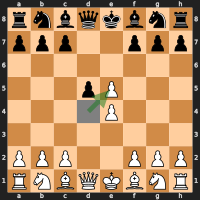

Board_Proxy (to Player_White):

***** Response from calling tool (call_oCKpHpDWConYWH4djzb7N5gH) *****
Moved pawn (♙) from d4 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_White (to Board_Proxy):

I've moved my pawn from d4 to e5. Your move!

--------------------------------------------------------------------------------
Player_White (to Player_Black):

I've moved my pawn from d4 to e5. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_Black):

I've moved my pawn from d4 to e5. Your move!

---------------------------------------------------------------------

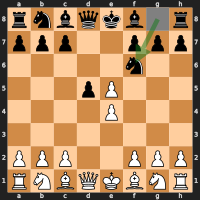

Board_Proxy (to Player_Black):

***** Response from calling tool (call_Z7E1uLs5xAZRNYXTudvM0n5S) *****
Moved knight (♞) from g8 to f6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_Black (to Board_Proxy):

I've moved the knight from g8 to f6. It's your turn!

--------------------------------------------------------------------------------
Player_Black (to Player_White):

I've moved the knight from g8 to f6. It's your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_White):

I've moved the knight from g8 to f6. It's your turn!

-------------------------------------------

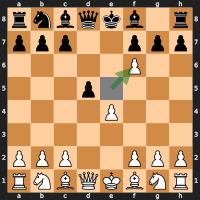

Board_Proxy (to Player_White):

***** Response from calling tool (call_JELiIQ6cRN5RgDKZBiC1Jfat) *****
Moved pawn (♙) from e5 to f6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_White (to Board_Proxy):

I've moved my pawn from e5 to f6. Your turn!

--------------------------------------------------------------------------------
Player_White (to Player_Black):

I've moved my pawn from e5 to f6. Your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_Black):

I've moved my pawn from e5 to f6. Your turn!

---------------------------------------------------------------------

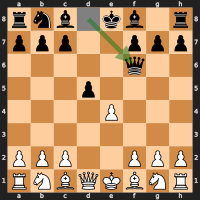

Board_Proxy (to Player_Black):

***** Response from calling tool (call_LHn7QxwqNw2m5cpq5SAPflZp) *****
Moved queen (♛) from d8 to f6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_Black (to Board_Proxy):

I've moved my queen from d8 to f6. Your turn!

--------------------------------------------------------------------------------
Player_Black (to Player_White):

I've moved my queen from d8 to f6. Your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_White):

I've moved my queen from d8 to f6. Your turn!

-----------------------------------------------------------------

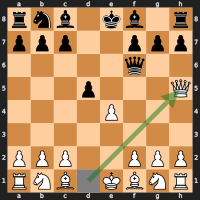

Board_Proxy (to Player_White):

***** Response from calling tool (call_3IPbMEjOMqcbHIpDzfz5uYGe) *****
Moved queen (♕) from d1 to h5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_White (to Board_Proxy):

I've moved my queen from d1 to h5. Your turn!

--------------------------------------------------------------------------------
Player_White (to Player_Black):

I've moved my queen from d1 to h5. Your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_Black):

I've moved my queen from d1 to h5. Your turn!

-----------------------------------------------------------------

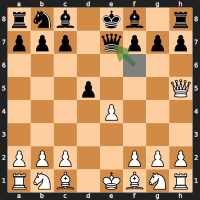

Board_Proxy (to Player_Black):

***** Response from calling tool (call_uJSa4JUuRmOGn52oEMZ6rUpp) *****
Moved queen (♛) from f6 to e7.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_Black (to Board_Proxy):

I have moved my queen from f6 to e7. Your turn!

--------------------------------------------------------------------------------
Player_Black (to Player_White):

I have moved my queen from f6 to e7. Your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_White):

I have moved my queen from f6 to e7. Your turn!

-----------------------------------------------------------

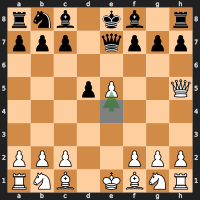

Board_Proxy (to Player_White):

***** Response from calling tool (call_5pbVkO2Gd1N5WGSY3mx4d8gV) *****
Moved pawn (♙) from e4 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_White (to Board_Proxy):

I have moved my pawn from e4 to e5. Your move!

--------------------------------------------------------------------------------
Player_White (to Player_Black):

I have moved my pawn from e4 to e5. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_Black):

I have moved my pawn from e4 to e5. Your move!

---------------------------------------------------------------

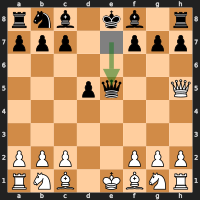

Board_Proxy (to Player_Black):

***** Response from calling tool (call_ENSh9DrRMjyU1eG9qnuvsQzs) *****
Moved queen (♛) from e7 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_Black (to Board_Proxy):

I have advanced my queen's pawn to e5. Your move!

--------------------------------------------------------------------------------
Player_Black (to Player_White):

I have advanced my queen's pawn to e5. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_White):

I have advanced my queen's pawn to e5. Your move!

-----------------------------------------------------

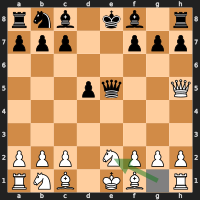

Board_Proxy (to Player_White):

***** Response from calling tool (call_y8hXAFg7t48RnrEmRPnhfk5D) *****
Moved knight (♘) from g1 to e2.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_White (to Board_Proxy):

I have moved my knight from g1 to e2. It's your move!

--------------------------------------------------------------------------------
Player_White (to Player_Black):

I have moved my knight from g1 to e2. It's your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_Black):

I have moved my knight from g1 to e2. It's your move!

----------------------------------------

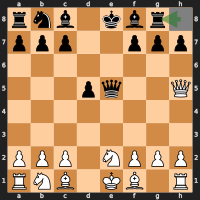

Board_Proxy (to Player_Black):

***** Response from calling tool (call_5L6t3JiX9j4Xw5dbRZ0KMukM) *****
Moved rook (♜) from h8 to g8.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_Black (to Board_Proxy):

I've moved the rook from h8 to g8. Your move!

--------------------------------------------------------------------------------
Player_Black (to Player_White):

I've moved the rook from h8 to g8. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_White):

I've moved the rook from h8 to g8. Your move!

------------------------------------------------------------------

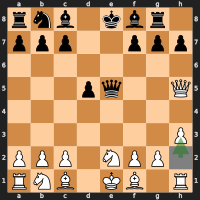

Board_Proxy (to Player_White):

***** Response from calling tool (call_aIImFbGwlyl6VHte8eCikQUP) *****
Moved pawn (♙) from h2 to h3.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_White (to Board_Proxy):

I've moved my pawn from h2 to h3. It's your move!

--------------------------------------------------------------------------------
Player_White (to Player_Black):

I've moved my pawn from h2 to h3. It's your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_Black):

I've moved my pawn from h2 to h3. It's your move!

------------------------------------------------------

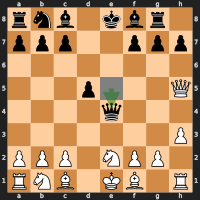

Board_Proxy (to Player_Black):

***** Response from calling tool (call_Yl1wja8IiKLV3RmTReHZI7s2) *****
Moved queen (♛) from e5 to e4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_Black (to Board_Proxy):

I've moved my queen from e5 to e4. Your move!

--------------------------------------------------------------------------------
Player_Black (to Player_White):

I've moved my queen from e5 to e4. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_White):

I've moved my queen from e5 to e4. Your move!

-----------------------------------------------------------------

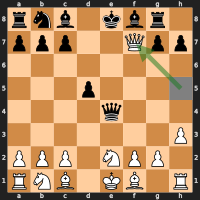

Board_Proxy (to Player_White):

***** Response from calling tool (call_nhjOshB7nkRUz5INLckiddn8) *****
Moved queen (♕) from h5 to f7.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_White (to Board_Proxy):

I've moved my queen from h5 to f7. Your turn!

--------------------------------------------------------------------------------
Player_White (to Player_Black):

I've moved my queen from h5 to f7. Your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_Black):

I've moved my queen from h5 to f7. Your turn!

-----------------------------------------------------------------

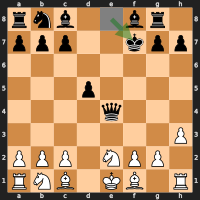

Board_Proxy (to Player_Black):

***** Response from calling tool (call_riPbuBUC1nU5W85gr6olTcnt) *****
Moved king (♚) from e8 to f7.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_Black (to Board_Proxy):

I've captured the queen on f7 with my king. Your move!

--------------------------------------------------------------------------------
Player_Black (to Player_White):

I've captured the queen on f7 with my king. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_White):

I've captured the queen on f7 with my king. Your move!

---------------------------------------

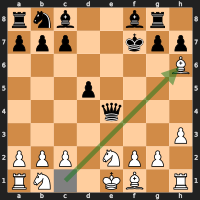

Board_Proxy (to Player_White):

***** Response from calling tool (call_NYnI41bP9lLGHoaRqxUBMNxS) *****
Moved bishop (♗) from c1 to h6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_White (to Board_Proxy):

I've moved my bishop from c1 to h6. Your move!

--------------------------------------------------------------------------------
Player_White (to Player_Black):

I've moved my bishop from c1 to h6. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_Black):

I've moved my bishop from c1 to h6. Your move!

-------------------------------------------------------------

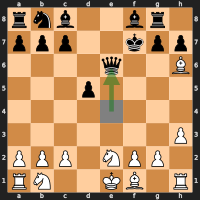

Board_Proxy (to Player_Black):

***** Response from calling tool (call_0JhbnAemekdWgQGKEJWg3FrH) *****
Moved queen (♛) from e4 to e6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_Black (to Board_Proxy):

I've moved my queen from e4 to e6. Your move!

--------------------------------------------------------------------------------
Player_Black (to Player_White):

I've moved my queen from e4 to e6. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_White):

I've moved my queen from e4 to e6. Your move!

-----------------------------------------------------------------

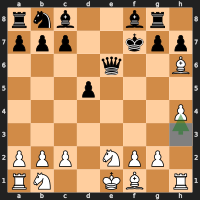

Board_Proxy (to Player_White):

***** Response from calling tool (call_LAaNkbKEYfGUVNU2nuWQzZPK) *****
Moved pawn (♙) from h3 to h4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_White (to Board_Proxy):

I've moved my pawn from h3 to h4. Your move!

--------------------------------------------------------------------------------
Player_White (to Player_Black):

I've moved my pawn from h3 to h4. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_Black):

I've moved my pawn from h3 to h4. Your move!

---------------------------------------------------------------------

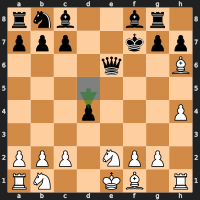

Board_Proxy (to Player_Black):

***** Response from calling tool (call_s4HAILVly18p7jHCGXcff2mW) *****
Moved pawn (♟) from d5 to d4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_Black (to Board_Proxy):

I've moved my pawn from d5 to d4, strengthening my center. Your move!

--------------------------------------------------------------------------------
Player_Black (to Player_White):

I've moved my pawn from d5 to d4, strengthening my center. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_White):

I've moved my pawn from d5 to d4, strengthening my center. Your m

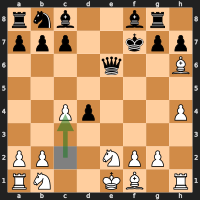

Board_Proxy (to Player_White):

***** Response from calling tool (call_mHwWvUASGyCmx13N0wV6vRIu) *****
Moved pawn (♙) from c2 to c4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_White (to Board_Proxy):

I've moved my pawn from c2 to c4. Your move!

--------------------------------------------------------------------------------
Player_White (to Player_Black):

I've moved my pawn from c2 to c4. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_Black):

I've moved my pawn from c2 to c4. Your move!

---------------------------------------------------------------------

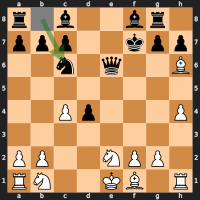

Board_Proxy (to Player_Black):

***** Response from calling tool (call_TzUQMfrcTHIr47dUk053F08K) *****
Moved knight (♞) from b8 to c6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_Black (to Board_Proxy):

I've moved my knight to c6. Your turn!

--------------------------------------------------------------------------------
Player_Black (to Player_White):

I've moved my knight to c6. Your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_White):

I've moved my knight to c6. Your turn!

--------------------------------------------------------------------------------

>>>

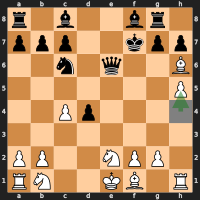

Board_Proxy (to Player_White):

***** Response from calling tool (call_UbLbokqHtJqrgeIzlEboDDi2) *****
Moved pawn (♙) from h4 to h5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_White (to Board_Proxy):

I've moved my pawn from h4 to h5. Your move!

--------------------------------------------------------------------------------
Player_White (to Player_Black):

I've moved my pawn from h4 to h5. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_Black):

I've moved my pawn from h4 to h5. Your move!

---------------------------------------------------------------------

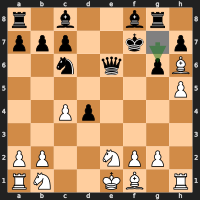

Board_Proxy (to Player_Black):

***** Response from calling tool (call_UaGExcXIQTXOnMRHs3Hcq8bc) *****
Moved pawn (♟) from g7 to g6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_Black (to Board_Proxy):

I have moved my pawn from g7 to g6. It's your move!

--------------------------------------------------------------------------------
Player_Black (to Player_White):

I have moved my pawn from g7 to g6. It's your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_White):

I have moved my pawn from g7 to g6. It's your move!

------------------------------------------------

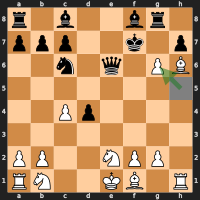

Board_Proxy (to Player_White):

***** Response from calling tool (call_KHI2JWa1exEdWab4UzBXgIIu) *****
Moved pawn (♙) from h5 to g6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_White (to Board_Proxy):

I have moved the knight from h5 to g6, capturing your pawn. Your move!

--------------------------------------------------------------------------------
Player_White (to Player_Black):

I have moved the knight from h5 to g6, capturing your pawn. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_Black):

I have moved the knight from h5 to g6, capturing your pawn. You

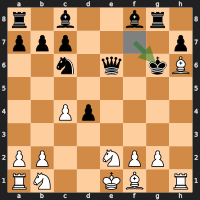

Board_Proxy (to Player_Black):

***** Response from calling tool (call_8SiSHokBasim59fJ0RIl2gSp) *****
Moved king (♚) from f7 to g6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_Black (to Board_Proxy):

I captured the knight on g6 with the king from f7. Your move!

--------------------------------------------------------------------------------
Player_Black (to Player_White):

I captured the knight on g6 with the king from f7. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_White):

I captured the knight on g6 with the king from f7. Your move!

------------------

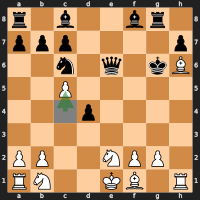

Board_Proxy (to Player_White):

***** Response from calling tool (call_0GEFG6GVw8EQ1Ka4voCoJ3kk) *****
Moved pawn (♙) from c4 to c5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_White (to Board_Proxy):

I've moved my pawn from c4 to c5. Your move!

--------------------------------------------------------------------------------
Player_White (to Player_Black):

I've moved my pawn from c4 to c5. Your move!

--------------------------------------------------------------------------------


In [21]:
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="Let's play chess! Your move.",
    max_turns=15,
)

# Let's add funny Chit Chat in the game...

In [26]:
player_white = ConversableAgent(
    name="Player_White",
    system_message="You are a chess player and you play as white. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move. "
    "After a move is made, chitchat to make the game fun.",
    llm_config=llm_config,
)

In [27]:
player_black = ConversableAgent(
    name="Player_Black",
    system_message="You are a chess player and you play as black. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move. "
    "After a move is made, chitchat to make the game fun.",
    llm_config=llm_config,
)

In [28]:
for caller in [player_white, player_black]:
    register_function(
        get_legal_moves,
        caller=caller,
        executor=board_proxy,
        name="get_legal_moves",
        description="Get legal moves.",
    )

    register_function(
        make_move,
        caller=caller,
        executor=board_proxy,
        name="make_move",
        description="Call this tool to make a move.",
    )

player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
            "summary_method": "last_msg",
            "silent": True,
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
            "summary_method": "last_msg",
            "silent": True,
        }
    ],
)

Player_Black (to Player_White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...
Call ID: call_urD2x3qPOqUkl1mMrsyMSk4p
Input arguments: {}

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...
Call ID: call_U1d6br7c5GpA0k2rDMAUGsiV
Input arguments: {'move': 'e2e4'}


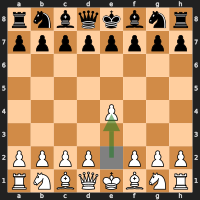


>>>>>>>> USING AUTO REPLY...
Player_White (to Player_Black):

I've moved my pawn to e4, a classic and strong opening move in chess — it opens lines for both my queen and bishop. What will be your response? Let's see what you've got!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...
Call ID: call_4ba5RT0dr1zMwzVr9K1qGLWo
Input arguments: {}

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...
Call ID: call_UiPbCFXnhX2tVRdqVpARIBpW
Input arguments: {'move': 'c7c5'}


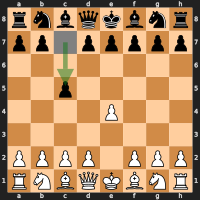


>>>>>>>> USING AUTO REPLY...
Player_Black (to Player_White):

Pawn to c5 is played! The Sicilian Defense is on the board. It's one of the most popular defenses against e4, favoring a dynamic and imbalanced game.

Since it's your move again, are you considering developing knights or bishops next, or perhaps pushing another pawn? How are you planning to maintain your central dominance?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...
Call ID: call_jICmBP56onT6EHBFTzQfcTyX
Input arguments: {}

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...
Call ID: call_JclqAlsWfakSI4efulkb0VNl
Input arguments: {'move': 'g1f3'}


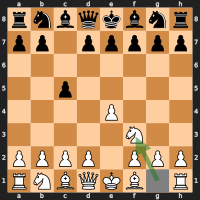


>>>>>>>> USING AUTO REPLY...
Player_White (to Player_Black):

I've moved the knight to f3, aiming to strengthen our control over the center and prepare for kingside castling. This move also puts pressure on key squares and starts to challenge your advances!

Now, it's your turn! What's your plan, aiming for a strong counterplay or solidifying your position further?

--------------------------------------------------------------------------------


In [29]:
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="Let's play chess! Your move.",
    max_turns=2,
)

# Note: To add human input in this game, add human_input_mode="ALWAYS" for both player agents.....right now it is set to NEVER.....